# Exploratory Data Analysis

## Выводы по данным:
* Датасет выглядит очень чистым с несколькими NaN значениями для замены в соответствии с признаком
* Категориальные переменные: OrdinalEncoder 
* Непрерывные переменные: Нормализация
* Некоторые неизвестные признаки, о которых нужно узнать:
    * Agent: ID агента/турфирмы
    * Lead time: время от момента бронирования до заезда
* Последние признаки *reservation_status* & *reservation_date* не добавлены в алгоритм, так как они коррелируют с *is_cancelled*

In [12]:
import os
from pathlib import Path

import pandas as pd

REPO_DIR = Path(os.path.realpath("")).parent

In [13]:
df = pd.read_parquet(REPO_DIR / "data/raw/hotel_bookings.parquet")

In [14]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [16]:
df.is_canceled.value_counts()

is_canceled
0    75166
1    44224
Name: count, dtype: int64

Данные не выглядят критически несбалансированными, поэтому дополнительная предобработка для этого не нужна.

## Features engineering

### Пропущенные значения (NaN)

In [17]:
count_na = df.isna().sum(axis=0)
count_na[count_na != 0]

children         4
country        488
agent        16340
company     112593
dtype: int64

### Categorical values

**Meal**

Тип питания

In [18]:
len(df.meal.unique())

5

**Countries**

In [19]:
len(df.country.unique())

178

Много уникальных категорий: риск проклятия размерности при использовании one-hot encoder. Попробуем OrdinalEncoder, а если он не сработает хорошо, то TargetEncoder.

**Market segment**

Рыночный сегмент

In [20]:
len(df.market_segment.unique())

8

In [21]:
df.market_segment.value_counts()

market_segment
Online TA        56477
Offline TA/TO    24219
Groups           19811
Direct           12606
Corporate         5295
Complementary      743
Aviation           237
Undefined            2
Name: count, dtype: int64

### Distribution channel 

Канал распределения

In [22]:
df.distribution_channel.unique()

array(['Direct', 'Corporate', 'TA/TO', 'Undefined', 'GDS'], dtype=object)

In [23]:
df.distribution_channel.value_counts()

distribution_channel
TA/TO        97870
Direct       14645
Corporate     6677
GDS            193
Undefined        5
Name: count, dtype: int64

### Тип забронированной комнаты и назначенной комнаты

Reserved room type & Assigned room type

In [24]:
len(df.reserved_room_type.unique())

10

In [25]:
len(df.assigned_room_type.unique())

12

### Изменения в бронировании

Похоже, что это категориальные данные

In [26]:
df.booking_changes.value_counts()

booking_changes
0     101314
1      12701
2       3805
3        927
4        376
5        118
6         63
7         31
8         17
9          8
10         6
13         5
14         5
15         3
16         2
17         2
12         2
11         2
20         1
21         1
18         1
Name: count, dtype: int64

Выбросы. Не будем учитывать их при предобработке

### Deposit type

In [27]:
df.deposit_type.value_counts()

deposit_type
No Deposit    104641
Non Refund     14587
Refundable       162
Name: count, dtype: int64

### Агент

Агент выглядит как категориальное значение. Возможно, это посредник для бронирования.

In [28]:
len(df.agent.unique())

334

### Компания

In [29]:
len(df.company.unique())

353

In [30]:
df.company.value_counts()

company
40.0     927
223.0    784
67.0     267
45.0     250
153.0    215
        ... 
104.0      1
531.0      1
160.0      1
413.0      1
386.0      1
Name: count, Length: 352, dtype: int64

### Тип клиента

In [31]:
df.customer_type.value_counts()

customer_type
Transient          89613
Transient-Party    25124
Contract            4076
Group                577
Name: count, dtype: int64

### Статус бронирования

In [32]:
df.reservation_status.value_counts()

reservation_status
Check-Out    75166
Canceled     43017
No-Show       1207
Name: count, dtype: int64

Стоит ли добавлять в модель? Наверное, нет, так как он напрямую коррелирует с *is_canceled*

## Причинно-следственные связи
Causality


Проверяем причинно-следственные связи между переменными

Check the causality between

In [33]:
causal_df = df[["is_canceled", "deposit_type", "reservation_status"]]
causal_df.sample(10)

,is_canceled,deposit_type,reservation_status
50654,1,Non Refund,Canceled
78136,0,No Deposit,Check-Out
116165,0,No Deposit,Check-Out
43938,1,Non Refund,Canceled
6058,1,No Deposit,Canceled
33763,0,No Deposit,Check-Out
50827,1,No Deposit,Canceled
19210,1,Non Refund,Canceled
23918,0,No Deposit,Check-Out
17856,0,No Deposit,Check-Out


Статус бронирования очевидно связан с целевой переменной ("Canceled")

In [34]:
# Check causality between a reservation canceled and Non Refund reservation.
is_canceled_df = causal_df.loc[causal_df["deposit_type"] == "Non Refund"]
is_canceled_df["is_canceled"].sum() / len(is_canceled_df)

0.9936244601357374

Почти каждый раз, когда депозит не возвращался, это было из-за отмены, что указывает на причинно-следственную связь.

In [35]:
%%latex
$$
encoding_{j} = countTarget1_{j} / totalOccurence_{j} 
$$

<IPython.core.display.Latex object>

##  Визуализация данных

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка стиля графиков
plt.style.use('default')
sns.set_palette("husl")

###  Распределение целевой переменной

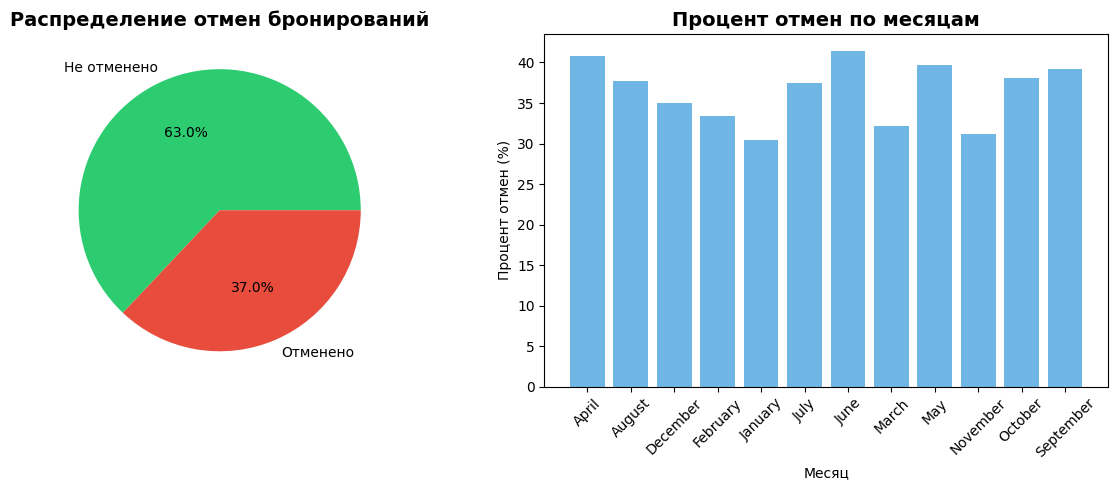

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Countplot для целевой переменной
ax1.pie(df['is_canceled'].value_counts(), 
        labels=['Не отменено', 'Отменено'],
        autopct='%1.1f%%', 
        colors=['#2ecc71', '#e74c3c'])
ax1.set_title('Распределение отмен бронирований', fontsize=14, fontweight='bold')

# Гистограмма по месяцам
monthly_data = df.groupby('arrival_date_month')['is_canceled'].agg(['count', 'sum']).reset_index()
monthly_data['cancel_rate'] = monthly_data['sum'] / monthly_data['count'] * 100

ax2.bar(monthly_data['arrival_date_month'], monthly_data['cancel_rate'], 
        color='#3498db', alpha=0.7)
ax2.set_title('Процент отмен по месяцам', fontsize=14, fontweight='bold')
ax2.set_xlabel('Месяц')
ax2.set_ylabel('Процент отмен (%)')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

###  Ключевые признаки

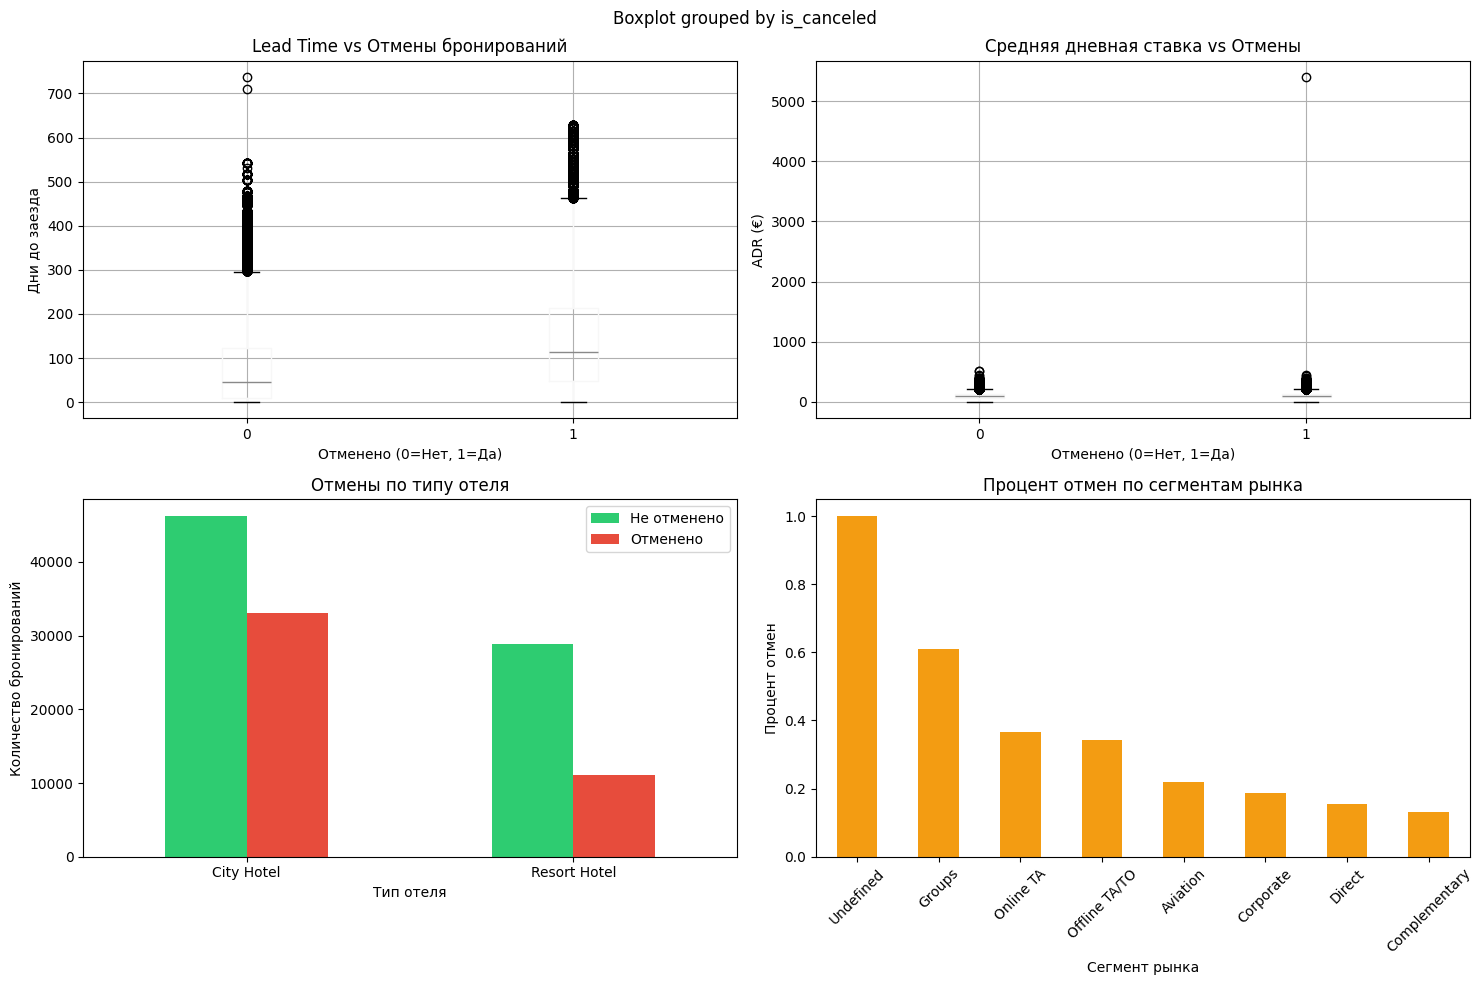

In [38]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Lead time vs Cancellation
df.boxplot(column='lead_time', by='is_canceled', ax=ax1)
ax1.set_title('Lead Time vs Отмены бронирований')
ax1.set_xlabel('Отменено (0=Нет, 1=Да)')
ax1.set_ylabel('Дни до заезда')

# ADR vs Cancellation  
df.boxplot(column='adr', by='is_canceled', ax=ax2)
ax2.set_title('Средняя дневная ставка vs Отмены')
ax2.set_xlabel('Отменено (0=Нет, 1=Да)')
ax2.set_ylabel('ADR (€)')

# Hotel type
hotel_cancel = df.groupby(['hotel', 'is_canceled']).size().unstack()
hotel_cancel.plot(kind='bar', ax=ax3, color=['#2ecc71', '#e74c3c'])
ax3.set_title('Отмены по типу отеля')
ax3.set_xlabel('Тип отеля')
ax3.set_ylabel('Количество бронирований')
ax3.legend(['Не отменено', 'Отменено'])
ax3.tick_params(axis='x', rotation=0)

# Market segment
market_cancel_rate = df.groupby('market_segment')['is_canceled'].mean().sort_values(ascending=False)
market_cancel_rate.plot(kind='bar', ax=ax4, color='#f39c12')
ax4.set_title('Процент отмен по сегментам рынка')
ax4.set_xlabel('Сегмент рынка')
ax4.set_ylabel('Процент отмен')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

###  Heatmap корреляций

In [39]:
# Выбираем только численные колонки для корреляции
numeric_cols = ['lead_time', 'arrival_date_week_number', 'arrival_date_day_of_month',
                'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
                'babies', 'previous_cancellations', 'previous_bookings_not_canceled',
                'booking_changes', 'days_in_waiting_list', 'adr', 
                'required_car_parking_spaces', 'total_of_special_requests', 'is_canceled']

correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Корреляция численных признаков с целевой переменной', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Топ корреляций с is_canceled
target_corr = correlation_matrix['is_canceled'].abs().sort_values(ascending=False)[1:]
print("🎯 Топ-10 признаков по корреляции с отменами:")
print(target_corr.head(10))

NameError: name 'np' is not defined

<Figure size 1200x1000 with 0 Axes>

In [ ]:
import numpy as np